## Deliverable 1: Current Distribution of Landlords, w.r.t to affordability and Distribution characteristics of affordable housing

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import googlemaps
from datetime import datetime
from dotenv import load_dotenv

load_dotenv()

False

#### Step 1.1: Get General Housing Data

In [3]:
# Read in the data
all_housing = pd.read_csv('./data/property-data.csv')
# all_housing = all_housing[['OWN_OCC', 'LU_DESC', 'UNIT_NUM', 'ZIPCODE', 'RES_UNITS']]
all_housing['ZIPCODE'] = all_housing['ZIPCODE'].apply(lambda x: str(x).zfill(5))


# Get the unique zip codes
afford_housing = pd.read_csv('./data/restricted-income-housing-2021-data.csv')
# convert Zip Code to int, if the value is NaN, leave as Nan
afford_housing['Zip Code'] = afford_housing['Zip Code'].fillna(-10).astype(np.int64)
# check if less than 5 digits, pad it with zeros
afford_housing['Zip Code'] = afford_housing['Zip Code'].apply(lambda x: str(x).zfill(5))

# explore the data
# all_housing.head()
afford_housing.head()

,Project Name,Neighborhood,Zip Code,TtlProjUnits,RentUnits,OwnUnits,TtlMarket,MarketRent,MarketOwn,Total Income-Restricted,Income-Restricted Rental,Income-Restricted Ownership,Tenure,Public/ Private,Includes Senior Units?,Section 8
0,Abbot Street/ Shawmut Ave,Roxbury,02119,16,16,0,0.0,0.0,0.0,16,16,0.0,Rental,Private,NaN,NaN
1,Academy Homes I,Roxbury,02119,202,202,0,52.0,52.0,0.0,150,150,0.0,Rental,Private,NaN,NaN
2,Academy Homes II,Roxbury,02119,236,236,0,0.0,0.0,0.0,236,236,0.0,Rental,Private,NaN,Y
3,Adams Court Phase A,Mattapan,02126,50,50,0,0.0,0.0,0.0,50,50,0.0,Rental,Private,NaN,NaN
4,Adams Court Phase B,Mattapan,02126,45,45,0,0.0,0.0,0.0,45,45,0.0,Rental,Private,NaN,NaN


In [111]:
# using the Google Places API to match affordable housing with an address
gmaps = googlemaps.Client(key=os.getenv('GOOGLE_API_KEY'))

def API_CALL(row):
    proj_name = row['Project Name']
    zip_code = row['Zip Code']
    places = gmaps.places(f"{proj_name} {zip_code}")
    if not places or not places['results']:
        return None
    if not "formatted_address" in places['results'][0]:
        return None
    return places['results'][0]['formatted_address']

afford_housing["formatted_address"] = afford_housing.apply(lambda x: API_CALL(x), axis=1)
afford_housing.to_csv('./data/affordable-housing-addresses.csv', index=False)

In [5]:
# filter out owner occupied housing
owner_housing = all_housing[all_housing['OWN_OCC'] == 'Y']
non_owner_housing = all_housing[all_housing['OWN_OCC'] == 'N']
res_units = all_housing['RES_UNITS'].sum()
res_non_owner_units = non_owner_housing['RES_UNITS'].sum()

print("Number of owner occupied housing:", len(owner_housing))
print("Percentage of owner occupied housing:", len(owner_housing) / len(all_housing))
print("Number of non-owner occupied housing:", len(non_owner_housing))
print("Number of residential units:", res_units)
print("Number of non-owner occupied residential units:", res_non_owner_units)
print("Percentage of non-owner occupied residential units:", res_non_owner_units/res_units)

Number of owner occupied housing: 78242
Percentage of owner occupied housing: 0.4380900122061837
Number of non-owner occupied housing: 100356
Number of residential units: 151611
Number of non-owner occupied residential units: 117175
Percentage of non-owner occupied residential units: 0.772866084914683


In [6]:
# Plot number of RentUnits and OwnUnits by zip code and sort by max sum of RentUnits and OwnUnits
afford_housing['TotalUnits'] = afford_housing['RentUnits'] + afford_housing['OwnUnits']
afford_housing = afford_housing.sort_values(by=['TotalUnits'], ascending=False)
afford_units = afford_housing['RentUnits'].sum()
print("Number of affordable housing units:", afford_units)
print("Percentage of affordable housing units of all non-owner residential housing units:", afford_units/res_non_owner_units)
print("Percentage of affordable housing units of all residential housing units:", afford_units/res_units)

Number of affordable housing units: 73665
Percentage of affordable housing units of all non-owner residential housing units: 0.6286750586729251
Percentage of affordable housing units of all residential housing units: 0.48588163128005224


In [7]:
# all housing units by zip code
owner_housing = owner_housing.groupby('ZIPCODE').sum()
owner_housing = owner_housing.reset_index()
owner_housing.head()

# affordable housing units by zip code
afford_housing = afford_housing.groupby('Zip Code').sum()
afford_housing = afford_housing.reset_index()
afford_housing.head()

/var/folders/wk/mfg9xrtx4qn70d9q4pb41xfr0000gn/T/ipykernel_99476/232501096.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  owner_housing = owner_housing.groupby('ZIPCODE').sum()
/var/folders/wk/mfg9xrtx4qn70d9q4pb41xfr0000gn/T/ipykernel_99476/232501096.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  afford_housing = afford_housing.groupby('Zip Code').sum()


,Zip Code,TtlProjUnits,RentUnits,OwnUnits,TtlMarket,MarketRent,MarketOwn,Total Income-Restricted,Income-Restricted Rental,Income-Restricted Ownership,TotalUnits
0,-0010,30,0,30,9.0,0.0,9.0,21,0,21.0,30
1,02108,96,96,0,0.0,0.0,0.0,96,96,0.0,96
2,02109,540,453,87,155.0,76.0,79.0,385,377,8.0,540
3,02110,609,369,240,567.0,337.0,230.0,42,32,10.0,609
4,02111,2570,2078,492,1322.0,950.0,372.0,1248,1128,120.0,2570


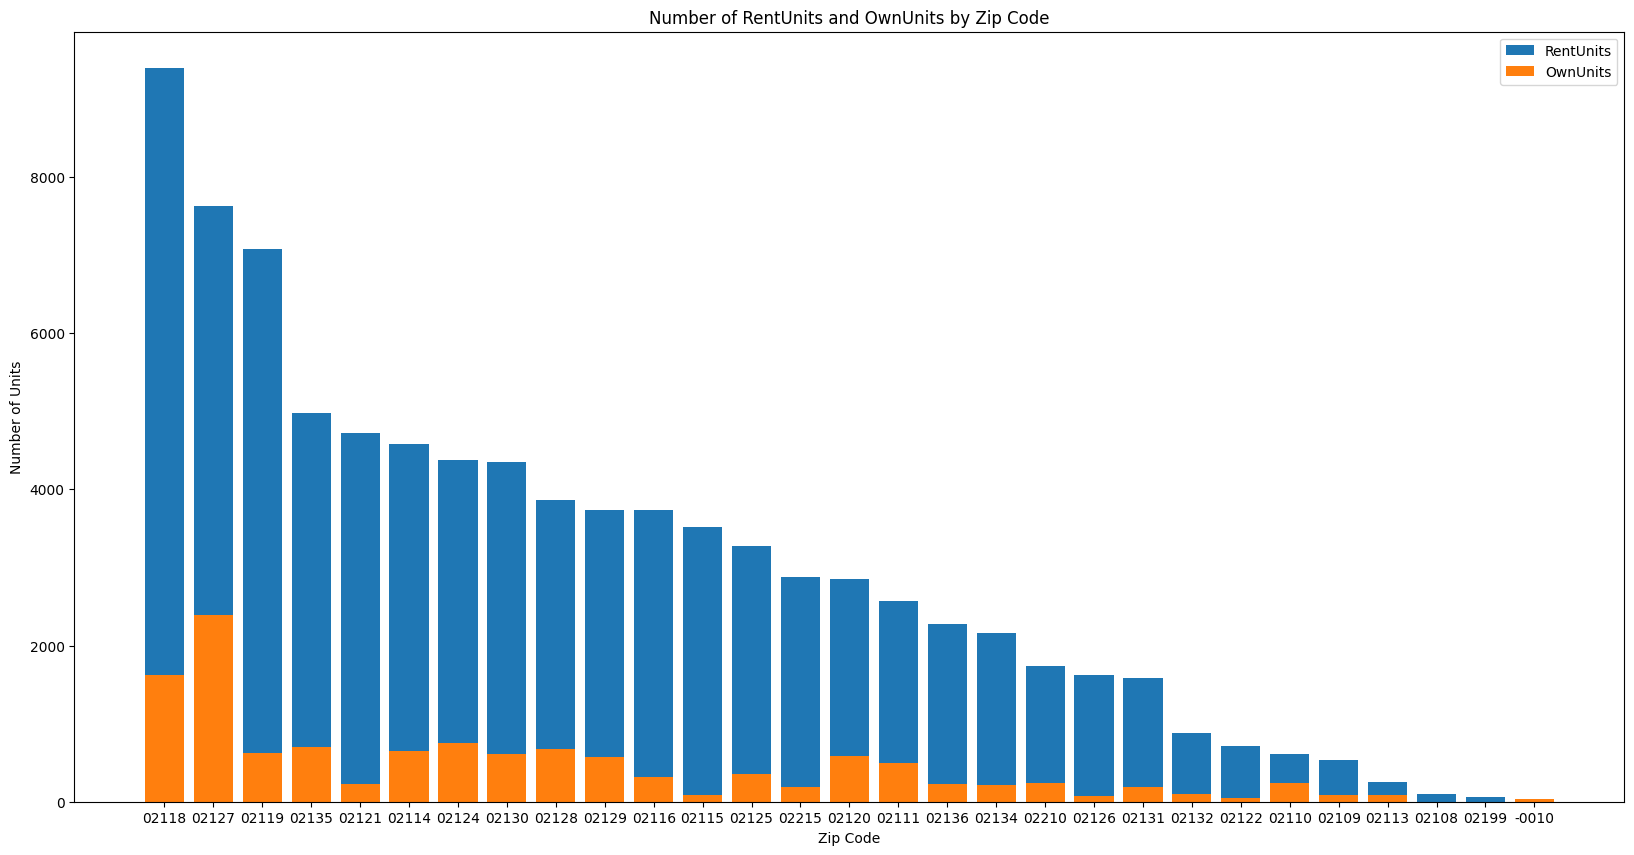

,Zip Code,TtlProjUnits,RentUnits,OwnUnits,TtlMarket,MarketRent,MarketOwn,Total Income-Restricted,Income-Restricted Rental,Income-Restricted Ownership,TotalUnits
9,02118,9389,7769,1620,3371.0,2061.0,1310.0,6018,5707,311.0,9389
17,02127,7627,5240,2387,3972.0,1829.0,2143.0,3655,3375,280.0,7627
10,02119,7071,6446,625,659.0,387.0,272.0,6412,6118,294.0,7071
24,02135,4978,4273,705,1795.0,1232.0,563.0,3183,3105,78.0,4978
12,02121,4715,4483,232,141.0,85.0,56.0,4574,4398,176.0,4715


In [21]:
# Plot number of RentUnits and OwnUnits by zip code and sort by max sum of RentUnits and OwnUnits
afford_housing['TotalUnits'] = afford_housing['RentUnits'] + afford_housing['OwnUnits']
afford_housing = afford_housing.sort_values(by=['TotalUnits'], ascending=False)

# sum by zip code
afford_housing = afford_housing.groupby('Zip Code').sum()
afford_housing = afford_housing.reset_index()
afford_housing.head()

# sort by total units
afford_housing = afford_housing.sort_values(by=['TotalUnits'], ascending=False)

# plot RentUnits and OwnUnits by zip code on the same bar with offset to show both
plt.figure(figsize=(20,10))
plt.bar(afford_housing['Zip Code'], afford_housing['RentUnits'], bottom=afford_housing['OwnUnits'], label='RentUnits')
plt.bar(afford_housing['Zip Code'], afford_housing['OwnUnits'], label='OwnUnits')
plt.xlabel('Zip Code')
plt.ylabel('Number of Units')
plt.title('Number of RentUnits and OwnUnits by Zip Code')
plt.legend()
plt.show()

afford_housing.head()

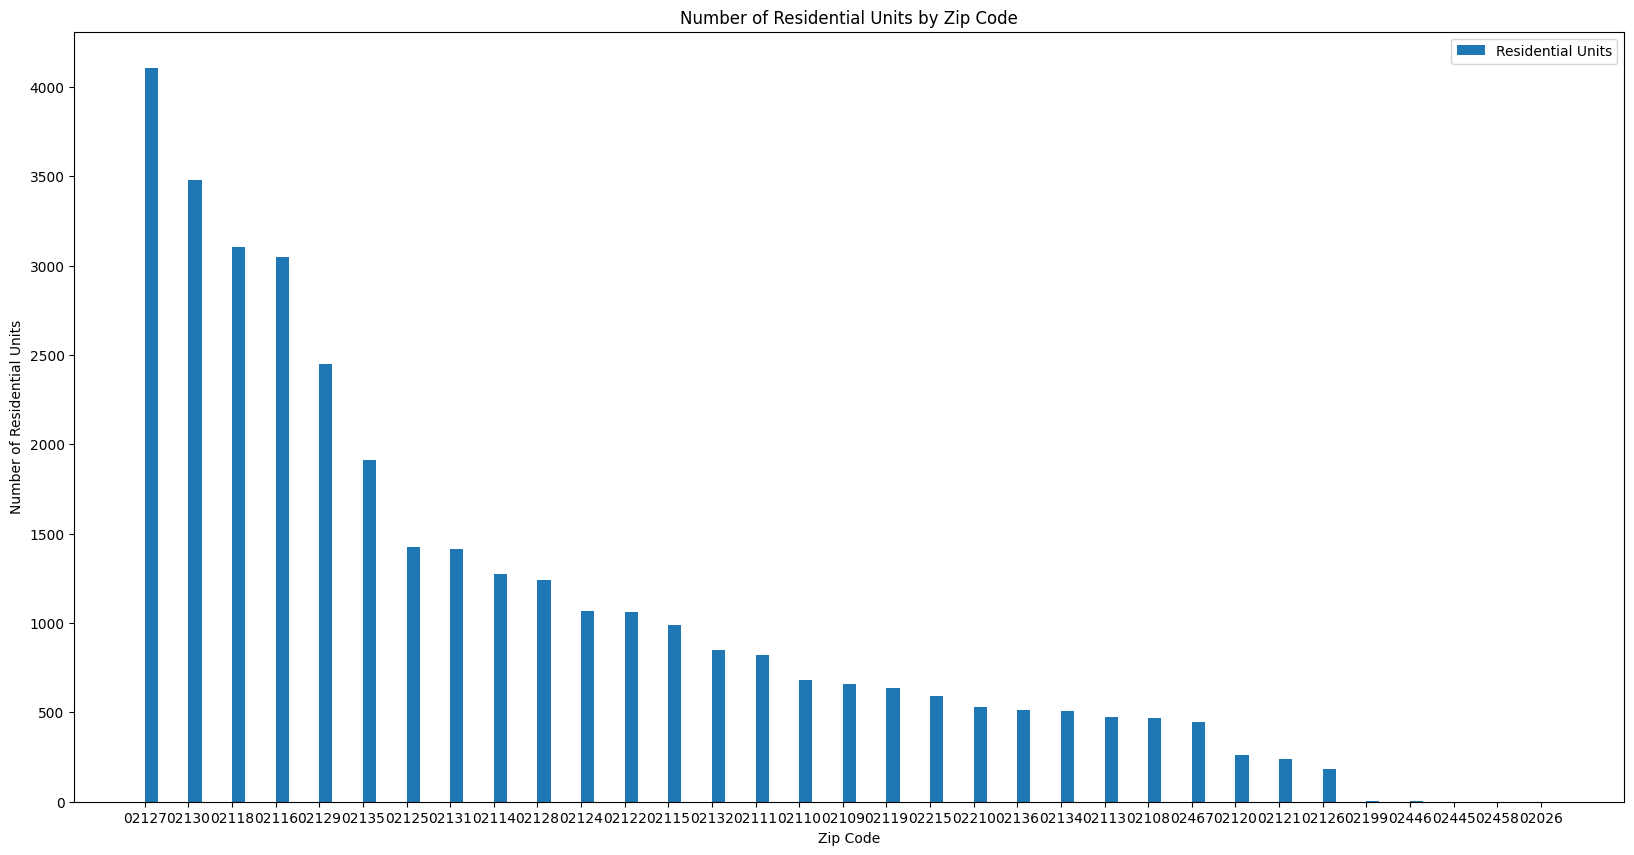

17    4103
20    3479
9     3103
8     3047
19    2449
Name: RES_UNITS, dtype: int64

In [12]:
# Visualize zip code data on all_housing
plt.figure(figsize=(20,10))

# sort by res_units
owner_housing = owner_housing.sort_values(by=['RES_UNITS'], ascending=False)

plt.bar(owner_housing['ZIPCODE'], owner_housing['RES_UNITS'], label='Residential Units', width=0.3, align='edge')
plt.xlabel('Zip Code')
plt.ylabel('Number of Residential Units')
plt.title('Number of Residential Units by Zip Code')
plt.legend()
plt.show()

# print out res_units for head
owner_housing['RES_UNITS'].head()

#### Overlay Income restricted housing data on top of general housing data

In [121]:
afford_housing = pd.read_csv('./data/affordable-housing-addresses.csv')
afford_housing.head()

,Project Name,Neighborhood,Zip Code,TtlProjUnits,RentUnits,OwnUnits,TtlMarket,MarketRent,MarketOwn,Total Income-Restricted,Income-Restricted Rental,Income-Restricted Ownership,Tenure,Public/ Private,Includes Senior Units?,Section 8,formatted_address
0,Abbot Street/ Shawmut Ave,Roxbury,2119,16,16,0,0.0,0.0,0.0,16,16,0.0,Rental,Private,NaN,NaN,"100 Shawmut Ave, Boston, MA 02118, United States"
1,Academy Homes I,Roxbury,2119,202,202,0,52.0,52.0,0.0,150,150,0.0,Rental,Private,NaN,NaN,"1592 Columbus Ave, Roxbury, MA 02119, United S..."
2,Academy Homes II,Roxbury,2119,236,236,0,0.0,0.0,0.0,236,236,0.0,Rental,Private,NaN,Y,"2926 Washington St, Roxbury, MA 02119, United ..."
3,Adams Court Phase A,Mattapan,2126,50,50,0,0.0,0.0,0.0,50,50,0.0,Rental,Private,NaN,NaN,"59 Msgr Patrick J Lydon Way, Boston, MA 02124,..."
4,Adams Court Phase B,Mattapan,2126,45,45,0,0.0,0.0,0.0,45,45,0.0,Rental,Private,NaN,NaN,NaN
